<a href="https://colab.research.google.com/github/hansneddyanto/Fintech/blob/main/stock_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Description: This program uses an artificial recurrent neural network called Long Short Term Memory (LSTM)
#              to predict the closing stock price of a corporation using the past years stock price.

# LSTM: Used in deep learning. Has feedback connections.
# Model 1

In [2]:
# Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
# Get the stock quote
from pandas import datetime

def parser(x):
  return datetime.strptime(x, '%Y-%m-%d')

from google.colab import files
uploaded = files.upload()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


Saving data.csv to data.csv


In [4]:
# Show data

data = pd.read_csv('data.csv',index_col=0, parse_dates=[0], date_parser=parser) 

# index_col is to make Date become the index (instead of the No. 0, 1, 2, 3...)
# The date is written as string, so what I'm doing here is making it into datetime format

data

,Open,High,Low,Close,Volume
Date,,,,,
2010-09-13,15400,15519,15320,15400,234851
2010-09-14,15500,15620,15200,15200,371530
2010-09-15,15260,15340,15020,15140,389289
2010-09-16,15080,15260,15080,15140,234815
2010-09-17,15240,15560,15159,15460,447649
...,...,...,...,...,...
2017-04-06,42000,42080,41600,41840,193668
2017-04-07,41800,41820,41160,41600,200420
2017-04-10,41940,41940,41500,41940,142827


In [5]:
# Get the number of rows and columns in the data set
data.shape

(1628, 5)

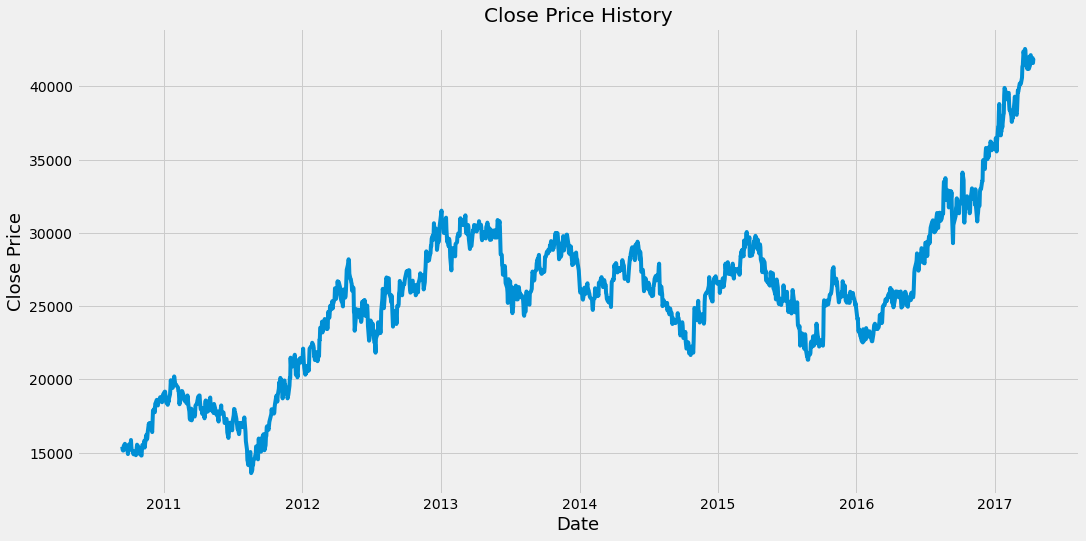

In [6]:
# Visualize the closing price history
plt.figure(figsize=(16, 8))
plt.title('Close Price History')
plt.plot(data['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.show()

In [7]:
# Create a new dataframe with only the 'Close column'
close = data.filter(['Close'])

# Convert the dataframe to a numpy array
dataset = close.values

# Get the number of rows to train the model on
# 80% will be used for training data
training_data_len = math.ceil( len(dataset) * 0.8 )

training_data_len

1303

In [8]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
# 0 and 1 are inclusive

scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.0621547 ],
       [0.05524862],
       [0.0531768 ],
       ...,
       [0.97859116],
       [0.96685083],
       [0.97720994]])

In [9]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:training_data_len , :]

# Split the data into x_train and y_train data sets
x_train = []    #Independent training variables/features
y_train = []    #Target variables

# We're using the past 60 days to predict the 61st day

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])     # Position 0 - 59
  y_train.append(train_data[i, 0])          # Position 60
  if i <= 60:
    print(x_train)                          # Just to see what's happening. The last 3 lines are not needed actually
    print(y_train)
    print()


[array([0.0621547 , 0.05524862, 0.0531768 , 0.0531768 , 0.06422652,
       0.06906077, 0.05662983, 0.05179558, 0.0448895 , 0.06353591,
       0.06698895, 0.06698895, 0.06906077, 0.06422652, 0.07803867,
       0.0621547 , 0.0538674 , 0.05041436, 0.04558011, 0.0441989 ,
       0.04834254, 0.05110497, 0.04903315, 0.04212707, 0.0448895 ,
       0.05870166, 0.06698895, 0.0628453 , 0.05732044, 0.05041436,
       0.05801105, 0.0448895 , 0.04627072, 0.04143646, 0.04143646,
       0.05732044, 0.06629834, 0.06767956, 0.06491713, 0.07596685,
       0.06008287, 0.06767956, 0.08839779, 0.09046961, 0.07941989,
       0.08218232, 0.09530387, 0.1160221 , 0.11049724, 0.11809392,
       0.11395028, 0.10842541, 0.10773481, 0.10082873, 0.09668508,
       0.12361878, 0.14779006, 0.14502762, 0.15262431, 0.14364641])]
[0.16367403314917128]



In [10]:
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [11]:
# Reshape the data set (because LSTM model expects 3D, not just 2D)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1243, 60, 1)

In [12]:
# Build the LSTM model
model = Sequential()

model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
# Add a layer with 50 neurons. 
# return_sequences is True because we're going to add another LSTM layer after this layer. 
# input_shape is the number of time steps (60, which is x_train.shape[1]) and number of features (1)

model.add(LSTM(50, return_sequences = False))
# Second layer will also have 50 layers
# return_sequences is False because we're not going to use any LSTM layers after this layer.

model.add(Dense(25))
# A regular densely connected neural network layer with 25 neurons

model.add(Dense(1))
# A layer with just 1 neuron

In [13]:
# Compile the model

# Optimizer to improve upon the loss function
# Loss function is to measure how well the model did on training, how far it is from the real data
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [14]:
# Train the model

# batch size is the total number of training examples present in the single batch. It's 1 because we don't want to further divide it into more batches.
# epochs is the number of iterations when the entire set has gone forward and backward
model.fit(x_train, y_train, batch_size=1, epochs=1)

1243/1243 [==============================] - 28s 21ms/step - loss: 0.0020


In [15]:
# Create the testing data set
# Create a new array containing scaled values from index 1243 to end (1628?).

test_data = scaled_data[training_data_len - 60:]

# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [16]:
# Convert the data into a numpy array, so that we can use it in the LSTM model
x_test = np.array(x_test)

In [17]:
# Reshape the data from 2D to 3D, because LSTM model needs 3D
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [18]:
# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)   # We're unscaling the values, and we want it to be the same as y_test dataset!

In [19]:
# Evaluate our model
# Get the root mean squared error (RMSE), how accurate the model is

rmse = np.sqrt( np.mean( predictions - y_test )**2)
rmse

# This is quite a good value, considering our data is at about ten thousands (the stock price)

421.12962139423075

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


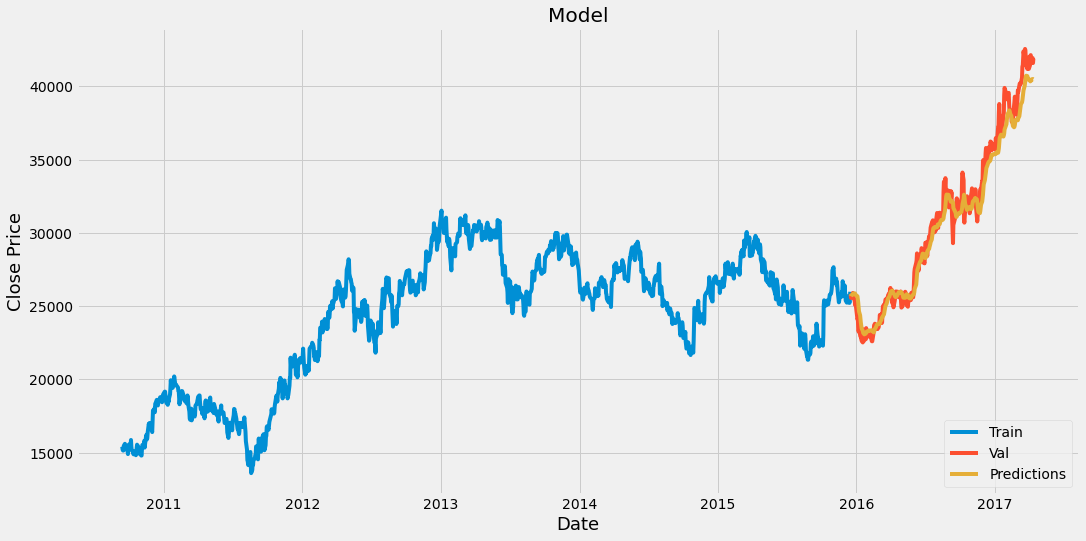

In [20]:
# Plot the data
train = close[:training_data_len]
valid = close[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')

# Seems good enough, even though the yellow line gets a little lower than the red line towards the end, I guess it's acceptable because the training set doesn't have that much of a jump in prices like it did in 2016-2017.

In [21]:
# Show the valid and predicted price

valid

,Close,Predictions
Date,,
2015-12-17,25800,25676.765625
2015-12-18,25560,25730.951172
2015-12-21,25600,25757.412109
2015-12-22,25840,25771.949219
2015-12-23,25900,25804.917969
...,...,...
2017-04-06,41840,40440.015625
2017-04-07,41600,40482.261719
2017-04-10,41940,40483.039062


In [22]:
# Now we start predicting the future values

# Get the quote
from google.colab import files
uploaded = files.upload()

new_quote = pd.read_csv('data.csv',index_col=0, parse_dates=[0], date_parser=parser) 


Saving data.csv to data (1).csv


In [23]:
# Create a new dataframe
new_data = new_quote.filter(['Close'])

# Get the last 60 days closing price values and convert the dataframe to an array
last_60_days = new_data[-60:].values

# Scale the data to be values between 0 and 1
# Notice that we are using variable from further up called 'scaler', the MinMaxScaler
# Not using fit transform because we want to use the MinMaxScaler when we first train and test the data
last_60_days_scaled = scaler.transform(last_60_days)

# Create an empty list
X_test = []

# Append the past 60 days into the X_test
X_test.append(last_60_days_scaled)

# Convert the X_test data set to a numpy array to use it to LSTM model
X_test = np.array(X_test)

# Reshape the data into 3D
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price
pred_price = model.predict(X_test)

#Undo the scaling
pred_price = scaler.inverse_transform(pred_price)

X_test = list(X_test)
pred_price = list(pred_price)
X_test.append(scaler.transform(pred_price))

print(pred_price)

# Just checking a few things for looping
# print(type(pred_price))
# print(type(new_data))
# print(type(last_60_days))
# print(type(X_test))

# print(X_test)

[array([40502.832], dtype=float32)]


In [24]:
# We will loop this process until we get
# There are 1086 data (days) that we need to predict

def predict(x):
  new_data = new_quote.filter(['Close'])
  last_60_days = new_data[-60:].values
  last_60_days_scaled = scaler.transform(last_60_days)
  pred_price_lst = []
  for i in range(x):
    X_test = []
    X_test.append(last_60_days_scaled)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    pred_price = model.predict(X_test)
    pred_price = scaler.inverse_transform(pred_price)
    pred_price = list(pred_price)
    pred_price_number = pred_price[0]
    pred_price_lst.extend(pred_price_number)

    last_60_days = list(last_60_days)
    last_60_days.extend(pred_price)
    last_60_days.pop(0)
    last_60_days_scaled = scaler.transform(last_60_days)
    #print(last_60_days)

    #X_test = []
    #X_test.append(last_60_days_scaled)
    #X_test.append(scaler.transform(pred_price))
    #X_test.extend(pred_price)
    #X_test.pop(0)
    #new_data.append(pred_price)
    #last_60_days.append(pred_price)
    #last_60_days.pop(0)
  return pred_price_lst
    

predict(1086)

[40502.832,
 40356.137,
 40148.17,
 39911.43,
 39663.242,
 39412.754,
 39164.76,
 38921.785,
 38685.105,
 38455.324,
 38232.65,
 38017.082,
 37808.504,
 37606.703,
 37411.434,
 37222.45,
 37039.47,
 36862.22,
 36690.445,
 36523.883,
 36362.305,
 36205.47,
 36053.168,
 35905.195,
 35761.36,
 35621.496,
 35485.42,
 35352.996,
 35224.066,
 35098.5,
 34976.168,
 34856.953,
 34740.742,
 34627.43,
 34516.91,
 34409.094,
 34303.89,
 34201.207,
 34100.973,
 34003.105,
 33907.523,
 33814.16,
 33722.953,
 33633.83,
 33546.727,
 33461.59,
 33378.363,
 33296.973,
 33217.387,
 33139.543,
 33063.395,
 32988.89,
 32915.992,
 32844.645,
 32774.816,
 32706.457,
 32639.531,
 32574.004,
 32509.828,
 32446.979,
 32385.414,
 32325.105,
 32266.018,
 32208.115,
 32151.377,
 32095.77,
 32041.262,
 31987.834,
 31935.45,
 31884.092,
 31833.73,
 31784.346,
 31735.906,
 31688.402,
 31641.795,
 31596.08,
 31551.232,
 31507.22,
 31464.041,
 31421.664,
 31380.076,
 31339.26,
 31299.193,
 31259.863,
 31221.254,
 3118

In [25]:
# Model 2 and model 3
# Model 2: linear regressor (lr)
# Model 3: support vector regressor (svr) model
!pip install quandl

In [26]:
# This program predicts stock prices by using machine learning models

# Install the dependencies
import quandl
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import pandas as pd
from pandas import datetime

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  # Remove the CWD from sys.path while we load stuff.


In [27]:
# Get the stock data

from google.colab import files
uploaded = files.upload()

def parser(x):
  return datetime.strptime(x, '%Y-%m-%d')
  
df = pd.read_csv('data.csv',index_col=0, parse_dates=[0], date_parser=parser)

Saving data.csv to data (2).csv


In [28]:
# Take a look at the data

print(df.head())

             Open   High    Low  Close  Volume
Date                                          
2010-09-13  15400  15519  15320  15400  234851
2010-09-14  15500  15620  15200  15200  371530
2010-09-15  15260  15340  15020  15140  389289
2010-09-16  15080  15260  15080  15140  234815
2010-09-17  15240  15560  15159  15460  447649


In [29]:
# Get the Close Price
df = df[['Close']]

# Take a look at the new data
print(df.head())

            Close
Date             
2010-09-13  15400
2010-09-14  15200
2010-09-15  15140
2010-09-16  15140
2010-09-17  15460


In [30]:
# A variable for predicting 'n' days out into the future
### We are predicting 1086 days out into the future
forecast_out = 1086

# Create another column (the target or dependent variable) shifted 'n' units up
# We shift it by the number of days we want to forecast_out

df['Prediction'] = df[['Close']].shift(-forecast_out)

# Print the new data set
# If forecast_out = 1, the data in the prediction is taken from close shifted up by 1, meaning...
# On 2010-09-13, when close is 15400, we want the prediction to be 15200. And so on...
print(df.head())

# Notice the NaN on the last day prediction
print(df.tail())



            Close  Prediction
Date                         
2010-09-13  15400     27320.0
2010-09-14  15200     27180.0
2010-09-15  15140     27160.0
2010-09-16  15140     27440.0
2010-09-17  15460     27900.0
            Close  Prediction
Date                         
2017-04-06  41840         NaN
2017-04-07  41600         NaN
2017-04-10  41940         NaN
2017-04-11  41600         NaN
2017-04-12  41900         NaN


In [31]:
# Create the independent data set (X)

# Convert the dataframe to a numpy array
# We remove/drop the Prediction column to create the independent data set!
X = np.array(df.drop(['Prediction'], 1))

# Remove the last 'n' rows, where n is forecast_out
# Just take note, the last 'n' rows will have NaN in their prediction
X = X[:-forecast_out]
print(X)

# X is a list of list

[[15400]
 [15200]
 [15140]
 [15140]
 [15460]
 [15600]
 [15240]
 [15100]
 [14900]
 [15440]
 [15540]
 [15540]
 [15600]
 [15460]
 [15860]
 [15400]
 [15160]
 [15060]
 [14920]
 [14880]
 [15000]
 [15080]
 [15020]
 [14820]
 [14900]
 [15300]
 [15540]
 [15420]
 [15260]
 [15060]
 [15280]
 [14900]
 [14940]
 [14800]
 [14800]
 [15260]
 [15520]
 [15560]
 [15480]
 [15800]
 [15340]
 [15560]
 [16160]
 [16220]
 [15900]
 [15980]
 [16360]
 [16960]
 [16800]
 [17020]
 [16900]
 [16740]
 [16720]
 [16520]
 [16400]
 [17180]
 [17880]
 [17800]
 [18020]
 [17760]
 [18340]
 [18380]
 [18600]
 [18580]
 [18320]
 [18220]
 [18520]
 [18640]
 [18720]
 [18780]
 [18720]
 [18500]
 [18440]
 [18760]
 [18900]
 [18980]
 [19160]
 [19160]
 [18840]
 [18600]
 [18420]
 [18340]
 [18260]
 [18600]
 [18440]
 [18660]
 [18980]
 [19380]
 [19940]
 [19640]
 [19420]
 [19420]
 [19500]
 [19960]
 [19880]
 [20200]
 [19620]
 [19660]
 [19440]
 [19220]
 [19200]
 [18720]
 [18300]
 [19060]
 [19160]
 [18900]
 [19080]
 [19200]
 [18960]
 [18760]
 [18600]
 

In [32]:
# Create the dependent data set (y)

# Convert the dataframe to a numpy array (All of the values including the NaNs)
y = np.array(df['Prediction'])

# Get all of the y values except the last 'n' rows
y = y[:-forecast_out]
print(y)

# y is a list

[27320. 27180. 27160. 27440. 27900. 27560. 27100. 26880. 27220. 27480.
 27540. 27340. 27340. 27580. 27500. 27140. 28460. 28360. 28740. 28440.
 28840. 28400. 28420. 29480. 28940. 29140. 29400. 29940. 30060. 29400.
 29280. 29340. 29520. 29700. 28420. 28420. 28560. 28820. 28460. 28680.
 28680. 29400. 29240. 29580. 29660. 29800. 29580. 29480. 28920. 29540.
 29000. 28600. 28880. 29220. 29020. 28200. 27900. 27320. 27700. 28200.
 28000. 27240. 27400. 26760. 26720. 26620. 26660. 26800. 26520. 26400.
 26760. 27320. 27040. 27000. 27240. 26280. 26180. 26140. 25820. 26060.
 25460. 26740. 26820. 26280. 25640. 25240. 25140. 25540. 25400. 25100.
 25080. 25300. 25320. 25620. 26420. 26040. 25380. 25560. 25620. 25360.
 25900. 25980. 25360. 24600. 24800. 24780. 25300. 25180. 25320. 24500.
 24700. 25640. 26100. 25500. 25260. 25060. 24680. 24580. 24600. 24600.
 25260. 24300. 23700. 23500. 23640. 23180. 22300. 22720. 22820. 23140.
 23080. 22800. 22080. 22620. 23080. 22780. 22020. 21580. 21580. 21340.
 21340

In [33]:
# Split the data into 80% training and 20% testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [34]:
# Create and train model 2
# Create and train the Support Vector Machine (Regressor)
# rbf is radio basis function (kernel)

# This is creating the model
svr_rbf = SVR(kernel='rbf', C=1e8, gamma=0.001)
# Seems like increasing C and decreasing gamma helps improve the svm confidence
# However, 1e3 and 0.001 seems like the best combo alr. If I change to C=1e9 or gamma=0.0001, the runtime will be too long (more than 10 mins)
# At first, I used C=1e3 and gamma=0.1, the svm confidence score is just 0.11

# Now we are training our data
svr_rbf.fit(x_train, y_train)

SVR(C=100000000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.001, kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
    verbose=False)

In [35]:
# Testing model: Score returns the coefficient of determination R^2 of the prediction
# The best possible score is 1.0
svm_confidence = svr_rbf.score(x_test, y_test)
print('svm confidence: ', svm_confidence)

# This score is quite bad, because 0.449 means that the confidence is just 45%
# But I think this might be because we are predicting 1086 days into the future, which is quite an impossible task
# Like how are you supposed to predict 1086 days into the future
# When I tried predicting 1 day into the future, the svm confidence is almost 80%

svm confidence:  0.6017639246039576


In [36]:
# Create and train the Linear Regression Model
# lr is for linear regression
lr = LinearRegression()

# Train the model
lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [37]:
# Testing model: Score returns the coefficient of determination R^2 of the prediction
# The best possible score is 1.0
lr_confidence = lr.score(x_test, y_test)
print('lr confidence: ', lr_confidence)

# lr confidence is better than svm confidence!

lr confidence:  0.659016254332086


In [38]:
# Set x_forecast equal to the last 1086 rows (-forecast_out) of the original data set from Close column
x_forecast = np.array(df.drop(['Prediction'], 1))[-forecast_out:]
print(x_forecast)

[[26620]
 [26140]
 [26640]
 ...
 [41940]
 [41600]
 [41900]]


In [39]:
# Print linear regression model predictions for the next 'n' days, where n is the forecast_out (1086)
# This one should be better than svm
lr_prediction = lr.predict(x_forecast)
print(lr_prediction)

[35188.209736   34698.28567981 35208.62323834 ... 50824.95252909
 50477.92298929 50784.1255244 ]


In [40]:
# Print support vector regressor model (svm)
svm_prediction = svr_rbf.predict(x_forecast)
print(svm_prediction)

[33819.90001293 30539.89991593 31740.10056003 ... 29169.88185295
 29169.88185295 29169.88185295]


In [41]:
# Oh wow, lr predicts the stock price will have an increasing trend, while svm predicts the stock price will have a decreasing trend
# Also notice that for the svm prediction, the last few data is just a constant value of 29177.68127879, so I think it's a bad prediction?

In [42]:
# Review of the three models
# Model 1: lstm
# Model 2: linear regression (lr)
# Model 3: support vector regression (svr)

# Model 1
# At first, I thought lstm will give the best possible model. But the outcome looks sketchy. It's not just a downward trend, it's actually decreasing day by day.
# Also, on the last days, the lstm give a constant stock price, which is impossible for stock prices. It's like the model stopped working already (sad)
# I think it can be improved if we can increase the number of layers, the number of neurons, and also the epochs, but it will take VERY LONG to train the data
# As for this exercise, I don't think I want to use model 1

# Model 2 and model 3
# Actually I feel lr and svr complement each other, in the sense that for some stocks, the confidence for lr is better than svr, while for other stocks, the confidence for svr is better than lr
# But in this case, the confidence for lr is better
# It must be noted that the confidence is less than 0.5 though, which is honestly a bad score
# But then again, I think it's very challenging to predict 1086 days into the future
# Another interesting point is that while the confidence for lr and svr are similar, they predict opposing trend (see above)

# I think comparing between lr and svr, I will chose lr because:
# 1. lr confidence is higher
# 2. For svr, the stock price on the last few days is constant, which makes it seem unreliable
# 3. This is a personal thing, but if I were to guess, I think the stock price will go up instead of going down based on my hunch.

# Hence, I choose model 3 as my final model

In [43]:
# I actually also tried AR and ARIMA, but somehow it didn't work for me because the variance of the model <<< the real variance (I think you guys should know already because I texted you guys about it)
# Do let me know if you want me to share the code! I saved it in another google colab file

In [48]:
# Converting the prediction (lr_prediction) to csv format
# I do this by editing the 0 from sample_submission file
import csv

from google.colab import files
uploaded = files.upload()

def parser(x):
  return datetime.strptime(x, '%Y-%m-%d')

Saving sample_submission.csv to sample_submission.csv


In [53]:
sample = pd.read_csv('sample_submission.csv',index_col=0, parse_dates=[0], date_parser=parser)

lr_prediction = list(lr_prediction)     # To make sure that lr_prediction is list

In [55]:
# Copy paste lr_prediction onto the predicted sample_submission

for i in range(len(lr_prediction)):        # len is 1086
  sample.iloc[i] = lr_prediction[i]        # iloc is pandas thing (index location?)

# Check if the predicted values are copied onto sample (sample_submission)
sample

# Create a file for this csv file!! YAYYYYY DONEEEE!!
sample.to_csv('fintech_submission_final_2.csv')
